In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
! git clone https://github.com/Shreya369/We-R.git

fatal: destination path 'We-R' already exists and is not an empty directory.


In [0]:
INvideos = pd.read_csv('We-R/YouTube_dataset/INvideos.csv')

In [16]:
INvideos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...
1,zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं..."
2,10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...
3,N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...
4,kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...


In [17]:
INvideos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 16 columns):
video_id                  37352 non-null object
trending_date             37352 non-null object
title                     37352 non-null object
channel_title             37352 non-null object
category_id               37352 non-null int64
publish_time              37352 non-null object
tags                      37352 non-null object
views                     37352 non-null int64
likes                     37352 non-null int64
dislikes                  37352 non-null int64
comment_count             37352 non-null int64
thumbnail_link            37352 non-null object
comments_disabled         37352 non-null bool
ratings_disabled          37352 non-null bool
video_error_or_removed    37352 non-null bool
description               36791 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 3.8+ MB


**DATA CLEANING**

In [18]:
# we can see in the info that the description column has NaN values, so we fill it with empty string
INvideos['description'] = INvideos['description'].fillna("")
INvideos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 16 columns):
video_id                  37352 non-null object
trending_date             37352 non-null object
title                     37352 non-null object
channel_title             37352 non-null object
category_id               37352 non-null int64
publish_time              37352 non-null object
tags                      37352 non-null object
views                     37352 non-null int64
likes                     37352 non-null int64
dislikes                  37352 non-null int64
comment_count             37352 non-null int64
thumbnail_link            37352 non-null object
comments_disabled         37352 non-null bool
ratings_disabled          37352 non-null bool
video_error_or_removed    37352 non-null bool
description               37352 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 3.8+ MB


In [0]:
# Some settings for plots
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

More about the data

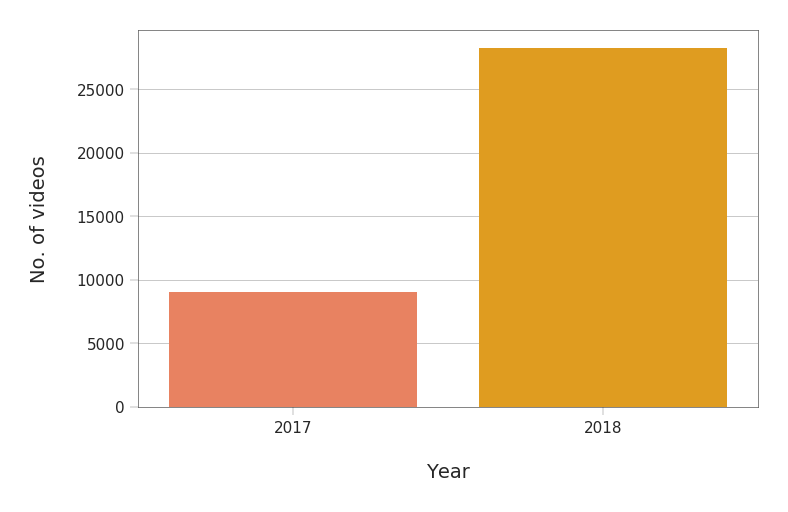

In [20]:
#Determining when the data was collected
INvideo = INvideos['trending_date'].apply(lambda x:'20'+x[:2]).value_counts().to_frame().reset_index().rename(columns={"index":"year","trending_date":"No_of_videos"})

#plot the result
fig,ax = plt.subplots()
yrs = sns.barplot(x="year",y="No_of_videos",palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7),data=INvideo,ax=ax)
yrs = ax.set(xlabel='Year',ylabel='No. of videos')

In [21]:
#some statistics about the important features to know the range of variation of these features for the trending videos.
INvideos.describe()

,category_id,views,likes,dislikes,comment_count
count,37352.00,37352.00,37352.00,37352.00,37352.00
mean,21.58,1060477.65,27082.72,1665.08,2677.00
std,6.56,3184932.05,97145.10,16076.17,14868.32
min,1.00,4024.00,0.00,0.00,0.00
25%,23.00,123915.50,864.00,108.00,81.00
50%,24.00,304586.00,3069.00,326.00,329.00
75%,24.00,799291.25,13774.25,1019.25,1285.00
max,43.00,125432237.00,2912710.00,1545017.00,827755.00


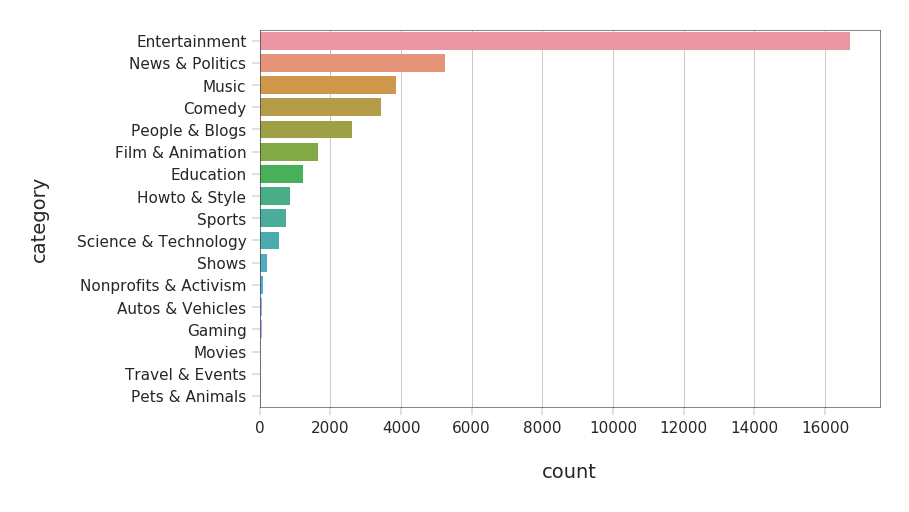

In [22]:
# To identify which are the common categories that goes viral

#Load the json file to match the category IDs to their respective category
categories = pd.read_json("We-R/YouTube_dataset/IN_category_id.json")
arr = categories["items"]
items = len(arr)

ids = []
for i in range(len(arr)):
    ids.append(categories["items"][i]['id'])

names = []
for i in range(len(arr)):
    names.append(categories["items"][i]["snippet"]["title"])

category = dict()
for i in range(len(names)):
    category[int(ids[i])] = names[i]
category[29] = "Nonprofits & Activism"

INvideos['Categories'] = [category[x] for x in INvideos['category_id']]
cat = INvideos['Categories'].value_counts().to_frame().reset_index().rename(columns={"index":"category","Categories":"count"})
sns.barplot(x="count",y="category",data = cat)

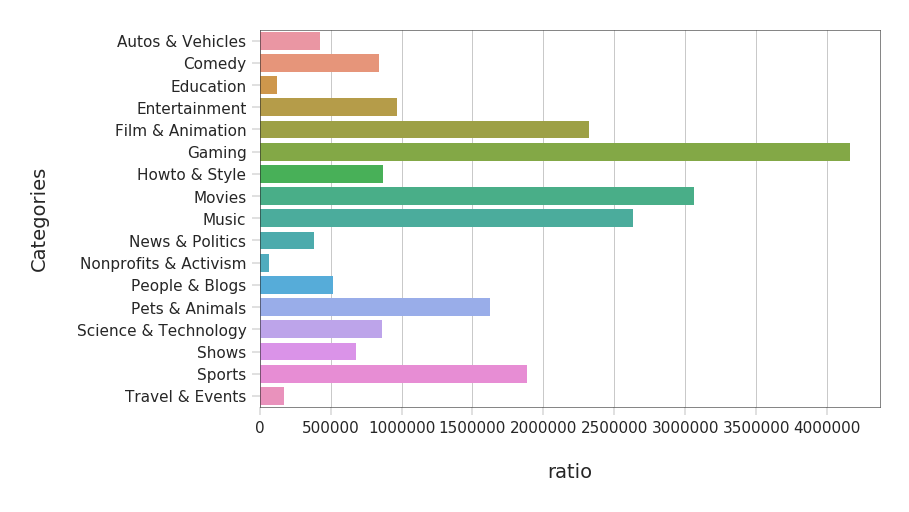

In [23]:
# Determine which categories are most viewed on an average :
view = INvideos[["Categories","views"]]
view_df = view.groupby("Categories").sum().reset_index()
coun = view.groupby("Categories").count().reset_index()
view_df['count'] = coun['views']
view_df['ratio'] = view_df['views']/view_df['count']
sns.barplot(x="ratio",y="Categories",data=view_df)

We can see from the above plot that on an average, the number of views are more in gaming and movie categories. The trending/popularity of the videos is not highly correlated with the number of views for that category videos as we can see that the number of views in gaming, movie,music and film/animation is greater than the no. of views in entertainment or News/politics category but there are more number of videos trending in the Entertainment and News/politics category. **Therefore,  the number of views for a video cannot decide the popularity of the video.**


#**Engagement of viewers**

In [0]:
INvideos['like_rate'] =  INvideos ['likes'] / INvideos['views'] * 100
INvideos['dislike_rate'] =  INvideos ['dislikes'] / INvideos['views'] * 100
INvideos['comment_rate'] =  INvideos ['comment_count'] / INvideos['views'] * 100